# Lecture 39: Privacy

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')

import datetime
import re

## Automated license plate readers in Oakland, CA

In [2]:
# source: https://data.oaklandnet.com/browse?q=alpr
alpr = Table.read_table('alpr_all.csv.gz', sep=',')\
  .relabeled('red_VRM', 'plate')\
  .relabeled('red_Timestamp', 'time')
alpr

plate,time,Location 1
6EZZ778,05/31/2014 12:41:00 PM,"(37.838856, -122.221971)"
4VLN123,05/31/2014 12:41:00 PM,"(37.838911, -122.222023)"
6EJR528,05/31/2014 12:41:00 PM,"(37.838911, -122.222023)"
5BEJ534,05/31/2014 12:41:00 PM,"(37.83896, -122.222071)"
6WQN812,05/31/2014 12:41:00 PM,"(37.839103, -122.22221)"
5RJP156,05/31/2014 12:41:00 PM,"(37.839228, -122.222323)"
5RZT811,05/31/2014 12:41:00 PM,"(37.839295, -122.222388)"
7CHA147,05/31/2014 12:41:00 PM,"(37.839596, -122.222893)"
7EEW593,05/31/2014 12:41:00 PM,"(37.839593, -122.222883)"
6PBE505,05/31/2014 12:40:00 PM,"(37.84137, -122.224333)"


In [3]:
p = re.compile('\((.*),(.*)\)')

def parse_latitude(s):
    m = p.match(s)
    return float(m.group(1))

def parse_longitude(s):
    m = p.match(s)
    return float(m.group(2))

alpr_latlon = alpr.with_columns(
    'latitude',  alpr.apply(parse_latitude,  'Location 1'),
    'longitude', alpr.apply(parse_longitude, 'Location 1')
).drop('Location 1')

alpr_latlon

plate,time,latitude,longitude
6EZZ778,05/31/2014 12:41:00 PM,37.8389,-122.222
4VLN123,05/31/2014 12:41:00 PM,37.8389,-122.222
6EJR528,05/31/2014 12:41:00 PM,37.8389,-122.222
5BEJ534,05/31/2014 12:41:00 PM,37.839,-122.222
6WQN812,05/31/2014 12:41:00 PM,37.8391,-122.222
5RJP156,05/31/2014 12:41:00 PM,37.8392,-122.222
5RZT811,05/31/2014 12:41:00 PM,37.8393,-122.222
7CHA147,05/31/2014 12:41:00 PM,37.8396,-122.223
7EEW593,05/31/2014 12:41:00 PM,37.8396,-122.223
6PBE505,05/31/2014 12:40:00 PM,37.8414,-122.224


In [4]:
def color_for_time(time):
    t = datetime.datetime.strptime(time, '%m/%d/%Y %I:%M:%S %p')
    if t.weekday() >= 6:
        return 'red' #weekend
    elif t.hour >= 6 and t.hour <= 17:
        return 'lightblue' #weekday daytime
    else:
        return 'darkblue' #weekday evening
    
alpr_latlon_color = alpr_latlon.with_column(
    'color', alpr.apply(color_for_time, 'time')
)
alpr_latlon_color

plate,time,latitude,longitude,color
6EZZ778,05/31/2014 12:41:00 PM,37.8389,-122.222,lightblue
4VLN123,05/31/2014 12:41:00 PM,37.8389,-122.222,lightblue
6EJR528,05/31/2014 12:41:00 PM,37.8389,-122.222,lightblue
5BEJ534,05/31/2014 12:41:00 PM,37.839,-122.222,lightblue
6WQN812,05/31/2014 12:41:00 PM,37.8391,-122.222,lightblue
5RJP156,05/31/2014 12:41:00 PM,37.8392,-122.222,lightblue
5RZT811,05/31/2014 12:41:00 PM,37.8393,-122.222,lightblue
7CHA147,05/31/2014 12:41:00 PM,37.8396,-122.223,lightblue
7EEW593,05/31/2014 12:41:00 PM,37.8396,-122.223,lightblue
6PBE505,05/31/2014 12:40:00 PM,37.8414,-122.224,lightblue


In [5]:
def map_plate(plate):
    sightings = alpr_latlon_color.where('plate', plate)
    t = sightings.select('latitude', 'longitude', 'time', 'color')
    return Marker.map_table(t)
    
most_seen = alpr_latlon_color.group('plate').sort('count', descending=True).column('plate').item(0)    
map_plate(most_seen)

In [6]:
the_mayor = '6FCH845'
map_plate(the_mayor)  

In [7]:
the_fire_chief = '1328354'
map_plate(the_fire_chief)

In [8]:
# unknown person
map_plate('6UZA652')

Is that kind of exploration ethical?

* For purposes of education?
* For purposes of curiousity?
* ...

## Voter Registration in Washington, DC

In [9]:
# source: https://github.com/ajschumacher/dc_voter_reg
dcvoters = Table.read_table('dcvoters.csv.zip', sep=',', na_filter=False, low_memory=False)
dcvoters

REGISTERED,LASTNAME,FIRSTNAME,MIDDLE,SUFFIX,STATUS,PARTY,RES_HOUSE,RES_FRAC,RES_APT,RESSTREET,RES_CITY,RES_STATE,RES_ZIP,RES_ZIP4,PRECINCT,WARD,ANC,SMD,VOTERID,071514-S,040114-P,042313-S,112012-G,052012-S,042012-P,022012-S,042011-S,112010-G,092010-P,112008-G,092008-P,022008-P,082007-S,052007-S,112006-G,092006-P,112004-G,092004-P,042004-S,012004-P,112002-G,092002-P,112000-G,092000-P,082000-P,012000-S,111999-G,111998-G,091998-P,081998-P,111997-G,091997-P,011997-S,111996-G,091996-P,081996-P,111995-G,091995-P,011995-S,111994-G
6/21/1996 0:00:00,BELL,MATTHEW,P,,A,DEMOCRATIC,3815,,,UPTON ST NW,WASHINGTON,DC,20016,,33,3,3F,3F01,000005466,N,E,E,E,N,E,E,E,E,E,E,E,E,N,E,E,E,E,E,,E,E,E,,,,,,,,,,,,,,,,,,
6/21/1996 0:00:00,VOID,LASHAWN,K,,A,NO PARTY,705,,,KENTUCKY AVE SE,WASHINGTON,DC,20003,,91,6,6B,6B09,000005468,N,N,E,E,N,N,E,E,E,N,E,N,N,N,N,E,N,E,N,,N,E,N,,,,,,,,,,,,,,,,,,
6/21/1996 0:00:00,WATKINS,KENDRA,A,,A,DEMOCRATIC,4268,,40,EAST CAPITOL ST NE,WASHINGTON,DC,20019,,102,7,7D,7D05,000005474,N,E,E,V,N,E,E,E,E,V,V,E,V,E,N,V,V,V,E,,E,V,V,V,,,,,,,,,,,,,,,,,
6/21/1996 0:00:00,WHEAT,KARIMA,S,,A,DEMOCRATIC,915,,,MISSOURI AVE NW,WASHINGTON,DC,20011,,58,4,4B,4B04,000005476,N,V,E,Y,N,E,V,E,V,V,V,E,V,N,V,V,V,V,E,,V,V,E,V,,,,,V,,,,,,,,,,,,
6/25/1996 0:00:00,CHASE,TANISHA,,,A,DEMOCRATIC,2311,,104,GOOD HOPE CT SE,WASHINGTON,DC,20020,,134,8,8B,8B01,000005508,E,V,E,Y,E,E,Y,E,Y,V,V,E,V,N,N,V,V,V,E,,V,E,V,,,,,,,,,,,V,V,,,,,,
6/25/1996 0:00:00,CLARK,JAMEL,T,,A,DEMOCRATIC,200,,,MALCOLM X AVE SE,WASHINGTON,DC,20032,,123,8,8C,8C01,000005510,E,E,E,E,N,E,E,E,E,E,E,E,E,N,N,E,E,V,E,,E,E,E,,,,,,,,,,,,,,,,,,
6/26/1996 0:00:00,DOCAL,SERGIO,R,,A,NO PARTY,4432,,,ALBEMARLE ST NW,WASHINGTON,DC,20016,,30,3,3E,3E01,000005579,N,N,E,E,N,N,E,E,E,N,V,N,N,N,E,E,N,V,N,,N,V,N,V,,,,,,,,,,,V,,,,,,
6/26/1996 0:00:00,KYLE,VINCENT,T,,A,DEMOCRATIC,718,,,HILLTOP TER SE,WASHINGTON,DC,20019,,106,7,7E,7E01,000005603,N,E,E,E,N,E,E,E,E,,E,E,E,N,E,E,E,E,E,,E,E,E,,,,,,,,,,,,,,,,,,
6/26/1996 0:00:00,TAYE,HAMERE,,,A,NO PARTY,3701,,F186,39TH ST NW,WASHINGTON,DC,20016,,29,3,3C,3C06,000005607,N,N,E,V,N,N,V,E,V,N,V,N,N,N,E,E,N,V,N,,N,V,N,V,,,,,V,,,,,,V,,,,,,
11/2/2004 0:00:00,WILLIAMS,OLGA,B,,A,DEMOCRATIC,6218,,,7TH ST NW,WASHINGTON,DC,20011,,59,4,4B,4B03,000005641,N,E,E,V,N,E,V,E,V,V,V,E,V,N,E,V,V,E,E,,E,E,E,V,,,,,,,,,,,V,,,,,,


In [10]:
clarksons = dcvoters.where('LASTNAME', 'CLARKSON')
clarksons

REGISTERED,LASTNAME,FIRSTNAME,MIDDLE,SUFFIX,STATUS,PARTY,RES_HOUSE,RES_FRAC,RES_APT,RESSTREET,RES_CITY,RES_STATE,RES_ZIP,RES_ZIP4,PRECINCT,WARD,ANC,SMD,VOTERID,071514-S,040114-P,042313-S,112012-G,052012-S,042012-P,022012-S,042011-S,112010-G,092010-P,112008-G,092008-P,022008-P,082007-S,052007-S,112006-G,092006-P,112004-G,092004-P,042004-S,012004-P,112002-G,092002-P,112000-G,092000-P,082000-P,012000-S,111999-G,111998-G,091998-P,081998-P,111997-G,091997-P,011997-S,111996-G,091996-P,081996-P,111995-G,091995-P,011995-S,111994-G
10/5/1972 0:00:00,CLARKSON,YVONNE,A,,A,DEMOCRATIC,809,,,3RD ST SW,WASHINGTON,DC,20024,,128,6,6D,6D03,000630342,N,V,V,Y,N,V,V,V,V,V,V,V,V,N,N,V,V,E,V,,V,V,V,V,V,,,,V,V,,V,,V,V,V,,,,,V
7/12/2001 0:00:00,CLARKSON,WILLIAM,,,A,REPUBLICAN,4805,,,SEDGWICK ST NW,WASHINGTON,DC,20016,,9,3,3D,3D02,MV092947,N,E,E,V,N,E,V,E,V,E,A,E,E,E,N,E,E,V,E,,N,E,V,,,,,,,,,,,,,,,,,,
2/25/2005 0:00:00,CLARKSON,JOHN,H,,A,DEMOCRATIC,2105,,,37TH ST NW,WASHINGTON,DC,20007,,11,3,3B,3B02,050007871,N,E,E,V,N,V,E,E,E,V,E,E,V,E,N,E,E,,,,,,,,,,,,,,,,,,,,,,,,
3/30/2006 0:00:00,CLARKSON,ADAM,J,,A,DEMOCRATIC,2480,,433,16TH ST NW,WASHINGTON,DC,20009,,24,1,1C,1C06,060002936,N,V,V,Y,N,E,V,V,V,V,V,E,V,N,N,V,V,,,,,,,,,,,,,,,,,,,,,,,,
10/6/2008 0:00:00,CLARKSON,GWINNETH,A,,A,DEMOCRATIC,3901,,604,CATHEDRAL AVE NW,WASHINGTON,DC,20016,,28,3,3B,3B04,080042106,N,E,E,E,N,E,E,E,E,E,V,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6/4/2009 0:00:00,CLARKSON,MARGUERITA,F,,A,REPUBLICAN,3700,,1124,9TH ST SE,WASHINGTON,DC,20032,,121,8,8E,8E06,090010092,E,E,E,E,N,E,V,E,V,V,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6/13/2009 0:00:00,CLARKSON,LAURA,H,,A,DEMOCRATIC,1150,,511,4TH ST SW,WASHINGTON,DC,20024,,128,6,6D,6D05,090010530,N,N,V,V,N,N,V,V,V,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6/21/2011 0:00:00,CLARKSON,JAMES,P,,A,NO PARTY,130,,538,M ST NE,WASHINGTON,DC,20002,,83,6,6C,6C06,110016642,N,N,V,V,N,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/16/2011 0:00:00,CLARKSON,MICHAEL,R,,A,DEMOCRATIC,1320,,301,21ST ST NW,WASHINGTON,DC,20036,,14,2,2B,2B06,110034058,N,E,E,V,N,E,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10/18/2011 0:00:00,CLARKSON,RACHEL,A,,A,DEMOCRATIC,1320,,301,21ST ST NW,WASHINGTON,DC,20036,,14,2,2B,2B06,110029215,N,E,E,V,N,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Just learned address.  How about age?

In [11]:
pop = Table.read_table('population_by_zip_2010.csv.zip', sep=',', dtype={'zipcode':str})\
  .relabeled('population', 'count').drop('geo_id')
pop

count,minimum_age,maximum_age,gender,zipcode
50,30,34,female,61747
5,85,nan,male,64120
1389,30,34,male,95117
231,60,61,female,74074
56,0,4,female,58042
524,22,24,female,75241
10,60,61,female,70631
13,80,84,female,17260
1,80,84,female,80612
68,15,17,female,54725


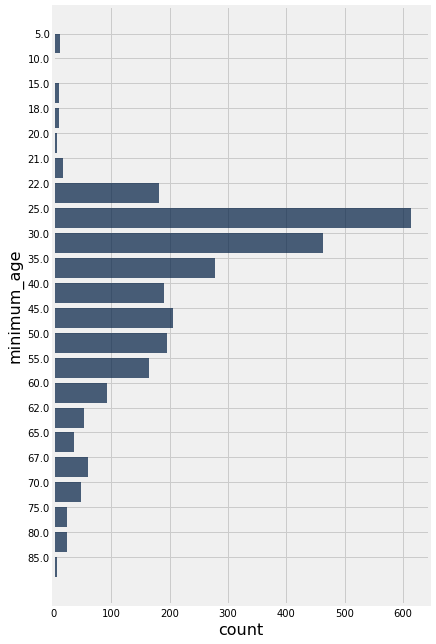

In [12]:
ages = pop.where('zipcode', '20036')\
  .where('gender', 'male')\
  .where('minimum_age', are.above(0))\
  .select('minimum_age', 'count')

ages.sort('minimum_age').barh('minimum_age')

In [13]:
dcvoters.where('RES_ZIP', '20052')

REGISTERED,LASTNAME,FIRSTNAME,MIDDLE,SUFFIX,STATUS,PARTY,RES_HOUSE,RES_FRAC,RES_APT,RESSTREET,RES_CITY,RES_STATE,RES_ZIP,RES_ZIP4,PRECINCT,WARD,ANC,SMD,VOTERID,071514-S,040114-P,042313-S,112012-G,052012-S,042012-P,022012-S,042011-S,112010-G,092010-P,112008-G,092008-P,022008-P,082007-S,052007-S,112006-G,092006-P,112004-G,092004-P,042004-S,012004-P,112002-G,092002-P,112000-G,092000-P,082000-P,012000-S,111999-G,111998-G,091998-P,081998-P,111997-G,091997-P,011997-S,111996-G,091996-P,081996-P,111995-G,091995-P,011995-S,111994-G
3/28/1996 0:00:00,DICKENS,SHEREENA,M,,A,NO PARTY,8797,,230,GEO WASH UNIV XXXX NW,WASHINGTON,DC,20052,,2,2,2A,2A08,000002241,N,N,E,E,N,N,E,E,E,N,E,N,N,E,N,E,N,E,N,,N,E,N,V,,,,,V,,,,,,V,,,,,,
9/26/2000 0:00:00,AHMAD,RASHA,I,,A,NO PARTY,412,,412,GEO WASH UNIV XXXX NW,WASHINGTON,DC,20052,,2,2,2A,2A08,000077354,N,N,E,E,N,N,E,E,E,N,E,N,N,E,N,E,N,E,N,,N,E,N,,,,,,,,,,,,,,,,,,
10/1/1992 0:00:00,YOERKIE,JENNIFER,L,,A,NO PARTY,1,,,GEO WASH UNIV XXXX NW,WASHINGTON,DC,20052,,2,2,2A,2A08,AB0456651,N,N,E,E,N,N,E,E,E,N,E,N,N,E,N,E,N,E,N,,N,E,N,,,,,,,,,,,,,,,,,,
8/16/2004 0:00:00,WILLIAMS,STACEY,M,,A,DEMOCRATIC,3900,,1,4TH ST SE,WASHINGTON,DC,20052,,121,8,8E,8E06,040007688,E,E,E,E,N,E,E,E,E,V,E,E,E,N,N,E,E,V,E,,,,,,,,,,,,,,,,,,,,,,
5/28/2008 0:00:00,COMBS,SUZANNE,J,,A,DEMOCRATIC,805,,,ALLISON ST NW,WASHINGTON,DC,20052,,46,4,4C,4C07,080016993,N,E,E,V,N,E,E,E,E,E,V,E,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10/28/2009 0:00:00,KNAPP,STEVEN,M,,A,DEMOCRATIC,1925,,,F ST NW,WASHINGTON,DC,20052,,2,2,2A,2A08,090020308,N,V,E,V,N,V,V,E,V,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11/6/2012 0:00:00,KAUL,PRANAV,K,,A,DEMOCRATIC,2100,,305,F ST NW,WASHINGTON,DC,20052,,2,2,2A,2A07,120070797,N,E,E,V,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11/6/2012 0:00:00,BONNETT,WILLIAM,T,III,A,NO PARTY,2100,,702,F ST NW,WASHINGTON,DC,20052,,2,2,2A,2A07,120070612,N,,E,V,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10/9/2012 0:00:00,BLECHMAN,ADAM,B,,A,REPUBLICAN,1,,,GEO WASH UNIV XXXX NW,WASHINGTON,DC,20052,,2,2,2A,2A08,120053167,N,E,E,A,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4/4/2014 0:00:00,LIEDHOLM,BRITTANY,M,,A,NO PARTY,2135,,806,F ST NW,WASHINGTON,DC,20052,,2,2,2A,2A08,140012450,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Steven Knapp (Cornell PhD 1981):  President of GWU 2007-2017

<hr/>

Does political party ever uniquely identify someone?

In [14]:
zip_party = dcvoters.group(['RES_ZIP','PARTY']).sort('count')
zip_party.where('count', 1).show()

RES_ZIP,PARTY,count
20001,UNKNOWN,1
20002,UNKNOWN,1
20003,UNKNOWN,1
20007,UNKNOWN,1
20011,,1
20019,UNKNOWN,1
20024,UNKNOWN,1
20030,DEMOCRATIC,1
20032,UNKNOWN,1
20052,STATEHOOD GREEN,1


## Linking

Some synthetic data.

In [15]:
voters = Table.read_table('kanon_voter.csv.zip', sep=',', dtype={'Zip':str})
voters

Name,Street,Zip,DOB,Sex,Party
John Smith,03Rd St,29148,1971/5/18,Male,Republican
Patricia Thompson,Avocet Way,14873,1984/5/8,Male,Republican
David Williams,Birchwood Ct,13148,1960/6/11,Male,Independent
Daniel Moore,Clement St,14845,1955/8/9,Male,Independent
Jennifer Lee,Teddy Ave,02148,1986/7/9,Female,Other
Elizabeth Smith,San Jose Av On Ramp,71483,1995/4/19,Female,Independent
Jennifer Jones,Butte Pl,14810,1987/7/2,Female,Independent
William Martin,Selma Way,89148,1967/1/17,Male,Independent
Joseph Moore,Dorado Ter,37148,1996/7/18,Male,Independent
Mary Smith,Meacham Pl,95148,1956/1/20,Female,Republican


In [16]:
hospital = Table.read_table('kanon_hospital.csv.zip', sep=',', dtype={'Zip':str})
hospital

Zip,DOB,Sex,Diagnosis
14843,1961/5/20,Male,pulmonary embolism w/o mcc
78148,1978/10/20,Female,septicemia or severe sepsis w/o mv 96+ hours w/o mcc
60148,1956/1/6,Male,other circulatory system diagnoses w mcc
19148,1938/6/24,Female,permanent cardiac pacemaker implant w cc
14847,1973/5/11,Female,respiratory system diagnosis w ventilator support 96+ hou
14882,1978/7/25,Male,cardiac arrhythmia & conduction disorders w cc
98148,1958/11/1,Female,heart failure & shock w cc
19148,1989/8/1,Male,hip & femur procedures except major joint w cc
76148,1949/7/14,Male,simple pneumonia & pleurisy w cc
24148,1935/3/17,Female,septicemia or severe sepsis w/o mv 96+ hours w/o mcc


In [17]:
unique_voters = voters.group(['Zip','DOB','Sex']).where('count', 1)
unique_voters

Zip,DOB,Sex,count
02148,1925/1/1,Male,1
02148,1925/1/23,Female,1
02148,1925/1/24,Female,1
02148,1925/1/25,Female,1
02148,1925/1/4,Male,1
02148,1925/1/8,Male,1
02148,1925/1/9,Female,1
02148,1925/10/12,Female,1
02148,1925/10/14,Male,1
02148,1925/10/15,Female,1


In [18]:
def de_anonymize_row(row):
    zip_code = row.item('Zip')
    dob = row.item('DOB')
    sex = row.item('Sex')
    matching = voters.where('Zip', zip_code).where('DOB', dob).where('Sex', sex)
    if matching.num_rows == 1:
        return matching.column('Name').item(0)
    else:
        return 'Not unique'
    
def de_anonymize_table(table):
    patients = table.with_column(
        'Name', table.apply(de_anonymize_row)
    ).where('Name', are.not_equal_to('Not unique'))
    return patients

In [19]:
first_10 = hospital.take(np.arange(0, 10))
de_anonymize_table(first_10)

Zip,DOB,Sex,Diagnosis,Name
14847,1973/5/11,Female,respiratory system diagnosis w ventilator support 96+ hou,Robert Anderson
14882,1978/7/25,Male,cardiac arrhythmia & conduction disorders w cc,Richard Davis
24148,1935/3/17,Female,septicemia or severe sepsis w/o mv 96+ hours w/o mcc,David Wilson


In [20]:
last_10 = hospital.take(np.arange(9990, 10000))
de_anonymize_table(last_10)

Zip,DOB,Sex,Diagnosis,Name
76148,1952/7/11,Male,transient ischemia,Charles Jackson
14845,1978/3/19,Male,seizures w/o mcc,Jennifer Thomas
32148,1966/1/23,Male,renal failure w mcc,Charles Jackson
78148,1971/8/26,Female,g.i. obstruction w/o cc/mcc,Jennifer Smith
61484,1950/10/24,Male,red blood cell disorders w mcc,David Martinez
71485,1976/12/20,Female,"fx, sprn, strn & disl except femur, hip, pelvis & thigh w",John Johnson
14853,1958/08/27,Female,extreme awesomeness,Martha Pollack


## k-anonymity

In [21]:
def anonymity_size(table, attributes):
    t = table.group(attributes).sort('count')
    return t

anonymity_size(hospital, ['Zip','DOB','Sex'])

Zip,DOB,Sex,count
02148,1926/10/27,Female,1
02148,1926/7/5,Male,1
02148,1927/1/2,Female,1
02148,1927/3/23,Male,1
02148,1927/8/7,Male,1
02148,1928/6/21,Female,1
02148,1930/10/19,Female,1
02148,1930/11/15,Female,1
02148,1930/11/27,Male,1
02148,1930/2/18,Male,1


In [22]:
anonymity_size(hospital, ['DOB','Sex'])

DOB,Sex,count
1925/1/11,Female,1
1925/1/13,Female,1
1925/10/9,Female,1
1925/6/23,Male,1
1925/7/21,Female,1
1925/7/9,Female,1
1925/8/16,Male,1
1925/8/8,Female,1
1925/9/26,Male,1
1925/9/27,Male,1


In [23]:
def extract_year(s):
    return s[0:4]

hospital_birthyear = hospital.with_column(
    'DOB', hospital.apply(extract_year, 'DOB')
)

anonymity_size(hospital_birthyear, ['DOB','Sex'])

DOB,Sex,count
1925,Female,6
1925,Male,6
1926,Female,11
1928,Female,12
1926,Male,13
1929,Male,14
1929,Female,15
1927,Female,16
1927,Male,19
1928,Male,19


In [24]:
anonymized_hospital = hospital_birthyear.drop('Zip')
anonymized_hospital

DOB,Sex,Diagnosis
1961,Male,pulmonary embolism w/o mcc
1978,Female,septicemia or severe sepsis w/o mv 96+ hours w/o mcc
1956,Male,other circulatory system diagnoses w mcc
1938,Female,permanent cardiac pacemaker implant w cc
1973,Female,respiratory system diagnosis w ventilator support 96+ hou
1978,Male,cardiac arrhythmia & conduction disorders w cc
1958,Female,heart failure & shock w cc
1989,Male,hip & femur procedures except major joint w cc
1949,Male,simple pneumonia & pleurisy w cc
1935,Female,septicemia or severe sepsis w/o mv 96+ hours w/o mcc


In [25]:
voters_birthyear = voters.with_column(
    'DOB', voters.apply(extract_year, 'DOB')
)

def de_anonymize_row_nozip(row):
    dob = row.item('DOB')
    sex = row.item('Sex')
    matching = voters_birthyear.where('DOB', dob).where('Sex', sex)
    if matching.num_rows == 1:
        return matching.column('Name').item(0)
    else:
        return 'Not unique'
    
def de_anonymize_table_nozip(table):
    patients = table.with_column(
        'Name', table.apply(de_anonymize_row_nozip)
    ).where('Name', are.not_equal_to('Not unique'))
    return patients

last_10_nozip = anonymized_hospital.take(np.arange(9990, 10000))
de_anonymize_table_nozip(last_10_nozip)

DOB,Sex,Diagnosis,Name
